In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
plt.rcparams = {"fontsize": 16}
fig_params = {"dpi": 100, "figsize": (7, 7)}

## Постановка задачи

Параметры для построения системы излучателей и приемников сигнала

In [75]:
# Omega сектор сканирования
Omega = [-0.1, 0.1]

# Длина волны излучателя
lambda_const = 2 * np.pi

# Волновое число 
k = 2 * np.pi / lambda_const

# Расстояние между излучателями-приемниками сигнала
d = 0.5

# Количество физических излучателей-приемников сигнала
N = 5

# Позиции целей
target_positions = [-0.028, 0.028]

# Дискретизация пространства Omega
n_discr = 100000
alpha = np.linspace(Omega[0], Omega[1], n_discr)
h = alpha[1] - alpha[0]

In [76]:
# Функция устройства ДН
def device_pattern(alpha, k=1.0, d=0.5, n=0):
  return np.exp(1j * k * d * n * alpha)


# Функция распознающей системы
def device_system(alpha, N=3, k=1.0, d=0.5):
  n = np.arange(-N, N+1)
  return np.sum(device_pattern(alpha=alpha[:, None], n=n[None, :], k=k, d=d), axis=1)

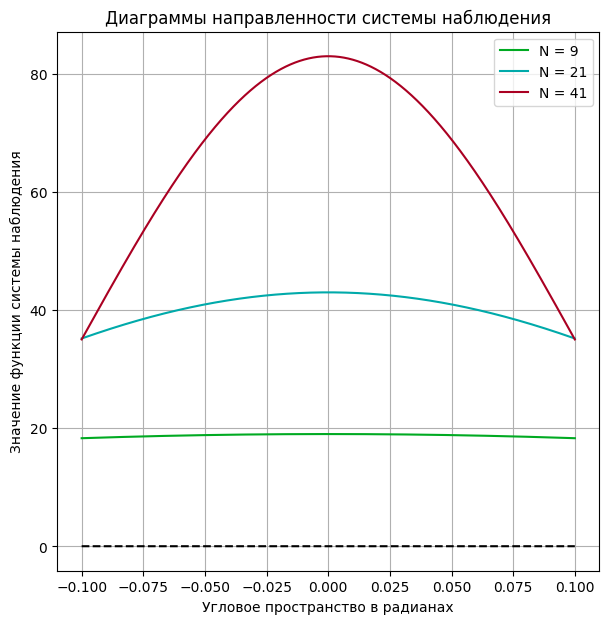

In [77]:
# Графики для диаграмм направленности с различным числом излучателей
plt.figure(**fig_params)
plt.title("Диаграммы направленности системы наблюдения")
plt.xlabel("Угловое пространство в радианах")
plt.ylabel("Значение функции системы наблюдения")
plt.plot(alpha, np.real(device_system(alpha, N = 9)), label = f"N = 9", color = "#00AA22")
plt.plot(alpha, np.real(device_system(alpha, N = 21)), label = f"N = 21", color = "#00AAAA")
plt.plot(alpha, np.real(device_system(alpha, N = 41)), label = f"N = 41", color = "#AA0022")
plt.plot(alpha, np.zeros(alpha.shape), color = "#000000", linestyle = "--")
plt.legend()
plt.grid()
plt.show()

In [78]:
targets = np.array(target_positions)
targets = np.mean(targets) - targets
targets
dist_between = np.abs(targets[0])

In [79]:
# Сигнал дельта-функций
def I_delta(alpha, beta = 0, magnitude = 600, power = 18, dist_between=0.028, window_rel = 1.52, k = 53.5, a = 0, gap = 0):
  return (np.abs(alpha - beta) <= window_rel * dist_between) * (magnitude * (np.sin(k * (alpha - beta + a * dist_between)) ** power + gap))

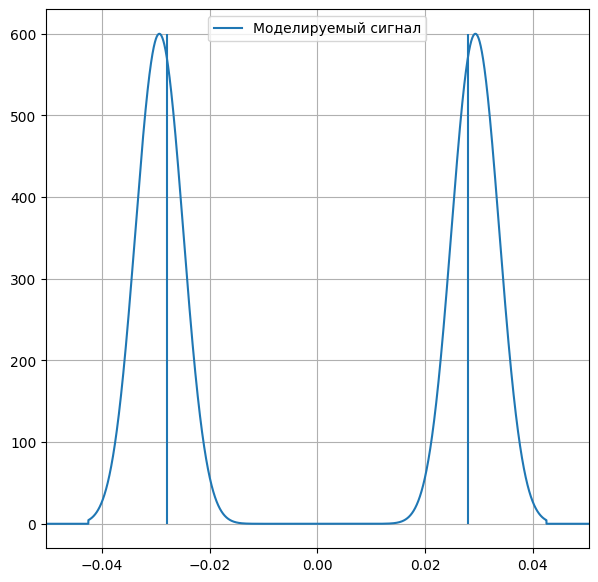

In [80]:
window_rel = 1.52
magnitude = 600
power = 18
gap = 0
a = 0
k = 53.5

plt.figure(**fig_params)
plt.plot(alpha, I_delta(alpha, dist_between=dist_between, window_rel=window_rel, 
                        magnitude=magnitude, gap=gap, power = power, a = a, k = k),
        label = "Моделируемый сигнал")
plt.xlim((-dist_between*1.8, dist_between*1.8))
plt.vlines(targets, 0, magnitude)
plt.legend()
plt.grid()
plt.show()

## Отраженный сигнал в виде дельта-функций

In [81]:
def U00(beta, dist_between=0.028, window_rel=1.4, k = 53.5, gap = 0, power = 18, magnitude = 600, a = 0):
    return integrate.quad(I_delta, 
                          -dist_between*window_rel,
                          dist_between*window_rel,
                         args = (beta, k, gap, a, magnitude, power, dist_between, window_rel))[0]

In [68]:
vec_U00 = np.vectorize(U00)

In [82]:
result = vec_U00(alpha)

In [71]:
result.shape == alpha.shape

True

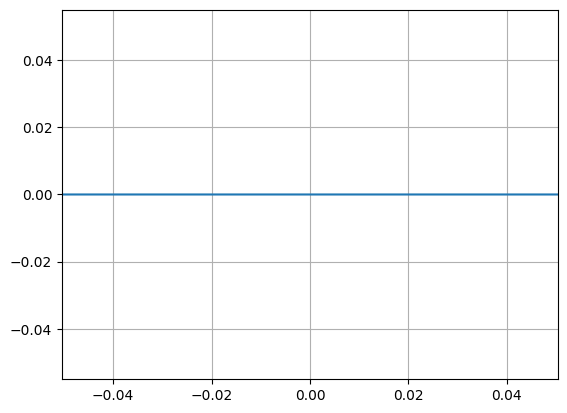

In [83]:
plt.plot(alpha, result)
plt.xlim((-dist_between*1.8, dist_between*1.8))
plt.grid()
plt.show()

## Поиск сигнала, принимаемого элементом системы измерения

In [ ]:
def Cn_deltas(n, k=1.0, d=0.5, Omega=[-1.0, 1.0], pos = [-0.5, 0.5], device_func = device_pattern):
  Cn = np.array(n.shape)
  for i in np.arange(n.shape[0]):
    Cn[i] = integrate.quad(lambda x: device_func(x, k=k, d=d, n=n), Omega[0], Omega[1])

## Отраженный сигнал в виде Гауссиан

In [ ]:
def gauss(x, A, sigma, position):
  return A * np.exp(-((x - position)**2)/(2 * (sigma ** 2)))

# Function of two spot signals
I_alpha = np.zeros(alpha.shape)
for i, pos in enumerate(target_positions):
  I_alpha += gauss(alpha, 1, 0.1, pos)

Text(0.5, 1.0, 'Функция двух источников сигнала')

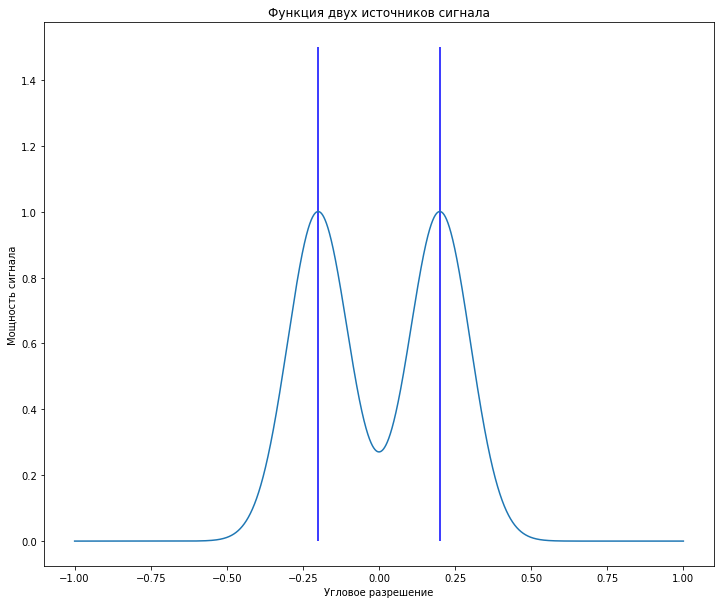

In [ ]:
plt.figure(figsize = (12, 10))
plt.plot(alpha, I_alpha)
plt.xlabel("Угловое разрешение")
plt.ylabel("Мощность сигнала")
plt.vlines(target_positions, 0, 1.5, color = "b")
plt.title("Функция двух источников сигнала")

In [ ]:
import torch
import torch.nn as nn

device_nn = (torch.device("cuda:0") 
if torch.cuda.is_available() else torch.device("cpu"))

In [ ]:
# Create the model
class AutoregressiveNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = torch.tanh(x)
        x = self.hidden_layer(x)
        x = torch.tanh(x)
        x = self.output_layer(x)
        return x

# Create the model instance
model = AutoregressiveNN(input_size=1, hidden_size=32, output_size=1)

# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(500):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print('Epoch [{}/500], Loss: {:.4f}'.format(epoch+1, loss.item()))

NameError: ignored